In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from keras.applications.vgg19 import VGG19, preprocess_input
import time
import cv2

In [2]:
def preprocess(img):
  img = tf.io.read_file(img)
  img = tf.image.decode_image(img)
  img = tf.cast(img, dtype=tf.float32)
  img = tf.expand_dims(img, axis=0)
  img = tf.image.resize(img, (256, 256))
  return img

def display(img):
  img = np.array(img)
  img = np.clip(img, 0, 255).astype("uint8")
  if len(img.shape) == 4:
    img = np.squeeze(img)

  plt.figure(figsize=(10, 5))
  plt.axis("off")
  plt.imshow(img)
  plt.show()


In [3]:
model = VGG19(include_top=False, weights="imagenet")
model.trainable = False
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [4]:
def gram_matrix(A):
  gram = tf.einsum("bijc,bijd->bcd", A, A)
  shape = tf.shape(A)
  i_j = tf.cast(shape[-2] * shape[-3], tf.float32)

  return gram/i_j

In [5]:
content_layer = "block4_conv1"

style_layers = [
    "block1_conv1" ,
    "block2_conv1" ,
    "block3_conv1" ,
    "block4_conv1" ,
    "block5_conv1" ,
    ]

def create_model():
  content_output = model.get_layer(content_layer).output
  style_outputs = [model.get_layer(style_layer).output for style_layer in style_layers]
  gram_outputs = [gram_matrix(output) for output in style_outputs]

  extractor = keras.Model(inputs=[model.input], outputs=[content_output, gram_outputs])
  return extractor

In [6]:
C_img = "Images/rabbit.png"
S_img = "Images/starry.png"

content = preprocess(C_img)
style = preprocess(S_img)

content.shape, style.dtype

(TensorShape([1, 256, 256, 3]), tf.float32)

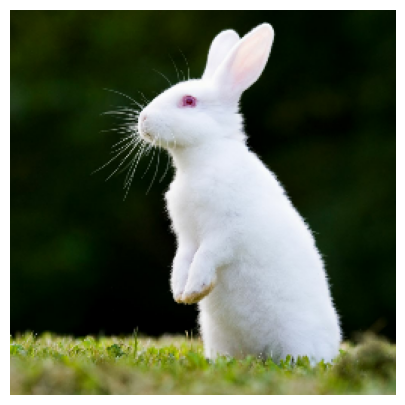

In [7]:
display(content)

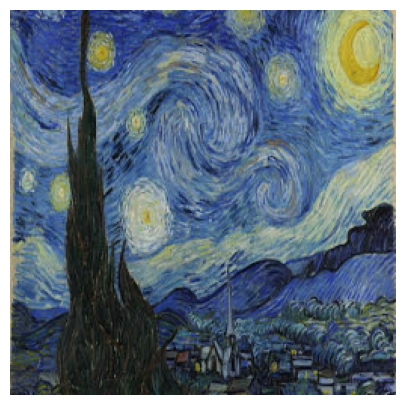

In [8]:
display(style)

In [9]:
extractor = create_model()
C = extractor(content)[0]
a_S = extractor(style)[1]

In [10]:
wpl = 1/len(style_layers)
def loss(a_G, a_S, G, C, w_1, w_2):
  style_loss = tf.add_n([tf.reduce_mean((G - S)**2) for G, S in zip(a_G, a_S)])/wpl
  content_loss = tf.reduce_mean((G - C)**2)
  total_loss = w_1*content_loss + w_2*style_loss

  return total_loss

In [14]:
def train(img, epoch, w_1 = 1e-4, w_2=1e-2):
  opt = Adam(learning_rate=0.2, beta_1=0.99)
  for i in range(epoch):
    with tf.GradientTape() as tape:
      outputs = extractor(img)
      total_loss = loss(outputs[1], a_S, outputs[0], C, w_1, w_2)
      print(f"Epoch: {i}")
      print(f"Loss: {total_loss}")

    grads = tape.gradient(total_loss, img)
    opt.apply_gradients([(grads, img)])
  return img

In [ ]:
generated = tf.Variable(content, dtype=tf.float32)
result = train(generated, epoch = 500)

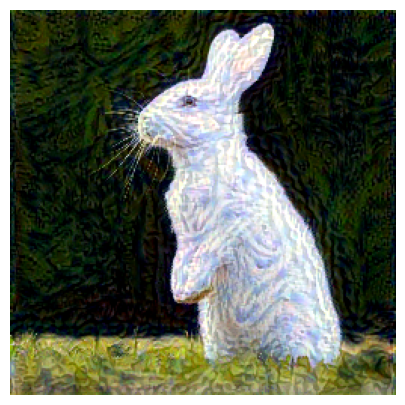

In [16]:
display(result)